In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr

from sklearn.metrics import accuracy_score

import logging

import sys
import os

from scipy.stats import binom_test
from mpl_toolkits.mplot3d import Axes3D
import math


In [3]:
class SuppressOutput:
    def __enter__(self):
        self.stdout = sys.stdout
        self.stderr = sys.stderr
        self.devnull = open(os.devnull, 'w')
        sys.stdout = self.devnull
        sys.stderr = self.devnull

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self.stdout
        sys.stderr = self.stderr


In [4]:
def filter_data(ticker_list, start, end):

    data_list = []

    for ticker in ticker_list:
        with SuppressOutput():
            data = yf.download(ticker, start=start, end=end)
        data_list.append(data)

    return dict(zip(ticker_list, data_list))
        

    

In [5]:
def create_data(ticker, ticker_name, l_wind, s_wind, wind):

    df = pd.DataFrame(ticker)
    date = df.index.tolist()
    df['Date'] = pd.to_datetime(date)

    df['Index'] = list(range(0, len(df['Date'])))

    large_window = l_wind
    small_window = s_wind
    window = wind

    # Calculate the moving average
    df['LMA'] = df['Open'].ewm(span=large_window, adjust=False).mean()
    df['SMA'] = df['Open'].ewm(span=small_window, adjust=False).mean()
    df['MA'] = df['Open'].ewm(span=window, adjust=False).mean()

    return df








In [6]:
def create_train_set(ticker_list, start_date, end_date, large_window, short_window, window):
    ticker_dict = filter_data(ticker_list, start_date, end_date)

    for ticker in ticker_dict.keys():
        data = ticker_dict.get(ticker)
        ticker_dict[ticker] = create_data(data, ticker, large_window, short_window, window)

    return ticker_dict


def train_model(ticker_dict, large_window, short_window, window):

    train_set = []

    for ticker in ticker_dict.keys():
        train_set = train_set + get_crossover_data(ticker_dict[ticker], window)

    lma = [lma for _, lma, _ in train_set]
    sma = [sma for _, _, sma in train_set]
    gain = [gain for gain, _, _ in train_set]

    fig = plt.figure(figsize = (20, 8))
    plt.scatter(lma, sma, c=gain, cmap='bwr', marker='o')

    # Add color bar
    cbar = plt.colorbar()
    cbar.set_label('Binary Value')

    plt.title("Scatter plot of winning (red) and losing (blue) trades based on rate of change in moving averages")
    plt.xlabel("Long-term Moving Average")
    plt.ylabel("Short-term Moving Average")

    # Show the plot
    plt.show()

    target = [target for target, _, _ in train_set]
    features = [(x,y) for _,x,y in train_set]

    print("Valid crossovers:", len(target))
    print("Successful crossovers:", target.count(1))

    model = RandomForestClassifier(n_estimators = 20, max_depth = 4)
    # model = LogisticRegression()
    model.fit(features, target)

    # Make predictions on the test set
    y_pred = model.predict(features)

    preds = list(y_pred)

    print(preds.count(1))

    correct_signals = 0

    trades = 0

    for i in range(0, len(preds)):
        confidence = model.predict_proba(np.array(features[i]).reshape(1, -1))[0, 1]
        if preds[i] == 1 and confidence > .7:
            trades += 1
            if preds[i] == target[i]:
                correct_signals += 1

    print("Amount of trades", trades)
    print("Amount of successful trades", correct_signals)
    # Calculate accuracy
    accuracy = accuracy_score(target, y_pred)
    print("Accuracy:", accuracy)

    return model



In [7]:
def create_test_set(ticker_list, start_date, end_date, large_window, short_window, window):
    ticker_dict = filter_data(ticker_list, start_date, end_date)

    for ticker in ticker_dict.keys():
        data = ticker_dict.get(ticker)
        ticker_dict[ticker] = create_data(data, ticker, large_window, short_window, window)

    return ticker_dict

def test_model(ticker_dict, large_window, short_window, window, model):

    train_set = []

    for ticker in ticker_dict.keys():
        train_set = train_set + get_crossover_data(ticker_dict[ticker], window)

    target = [target for target, _, _ in train_set]
    features = [(x,y) for _,x,y in train_set]

    print("Valid crossovers:", len(target))
    print("Successful crossovers:", target.count(1))

    # Make predictions on the test set
    y_pred = model.predict(features)

    preds = list(y_pred)

    print("Predicted successful crossovers:", preds.count(1))

    correct_signals = 0

    trades = 0

    for i in range(0, len(preds)):
        confidence = model.predict_proba(np.array(features[i]).reshape(1, -1))[0, 1]
        if preds[i] == 1 and confidence > .8:
            trades += 1
            if preds[i] == target[i]:
                correct_signals += 1

    print("Amount of trades", trades)
    print("Amount of successful trades", correct_signals)
    # Calculate accuracy
    accuracy = accuracy_score(target, y_pred)
    print("Accuracy:", accuracy)

    return (correct_signals / trades, target.count(1) / len(target))



In [8]:
window = 200
large_window = 80
small_window = 20


In [10]:
start_date = '2020-09-01'
end_date = '2023-08-31'

recent_start = '2022-08-01'
recent_end = '2023-09-05'

long_start = '2013-08-31'
long_end = '2023-08-31'

train_start = '2010-08-31'
train_end = '2018-08-31'

init_start = '2001-08-31'
init_end = '2010-08-31'

sp_df = pd.read_csv('symbols.csv')

sp_list = list(sp_df['Symbol'])

common_list = commonly_traded_stocks = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "META", "TSLA", "NVDA", "NFLX", "JPM", "V",
    "JNJ", "PG", "WMT", "KO", "MCD", "HD", "BA", "INTC", "CRM", "ADBE",
    "PFE", "T", "XOM", "CVX", "IBM", "GE", "VZ", "DIS", "MA", "BAC",
    "CMCSA", "TMO", "MRK", "UNH", "NKE", "WFC", "PYPL", "CSCO", "PEP",
    "PM", "BMY", "ABBV", "LLY", "CVS", "GILD", "QCOM", "DHR", "AMGN",
    "COST", "MCD", "TXN", "LIN", "NOW", "PFE", "LMT", "NEE", "TGT",
    "FDX", "HON", "ACN", "UNH", "LOW", "KHC", "DUK", "AAL", "NOC",
    "MET", "INTU", "UPS", "C", "SBUX", "ORCL", "NEE", "AMD", "DE",
    "ISRG", "CAT", "AMAT", "MO", "WBA", "MDT", "VRTX", "MS", "SYK",
    "MMM", "TMO", "PLD", "INTC", "ADI", "GS", "GM", "BDX", "VLO",
    "CL", "CI", "MDLZ", "SPGI", "CCI", "SO", "ANTM", "FISV", "AXP",
    "GILD", "SYF", "BDX", "SPG", "TROW", "CNC", "DELL", "ZTS", "SNPS"
]

common_ticks = [
    "TSLA", "NIO", "AMD", "WBD", "NU", "TLRY", "NVDA", "AAPL", "PLTR", "INTC",
    "AMZN", "BAC", "F", "VALE", "WBA", "PARA", "XPEV", "DELL", "DNA", "DIS",
    "NUVA", "KVUE", "RIVN", "BEKE", "MARA", "GRAB", "GOOGL", "BKI", "LCID", "T",
    "HPE", "RIG", "AFRM", "CMCSA", "SWN", "SNAP", "OPEN", "SOFI", "PFE", "BABA",
    "HZNP", "CCL", "GOOG", "LYFT", "S", "MSFT", "XOM", "AAL", "VZ", "UBER", "KMI",
    "CSCO", "GSAT", "SHOP", "USB", "PDD", "META", "WFC", "C", "BBD", "CSX", "NOK",
    "GOLD", "JD", "LU", "PYPL", "IQ", "KEY", "KO", "PLUG", "FCX", "MU", "DG", "CVNA",
    "PCG", "RYCEY", "SIRI", "TAL", "BCS", "CHWY", "MRO", "IOT", "NTNX", "HPQ", "KGC",
    "XP", "HBAN", "YMM", "SCHW", "DVN", "RBLX", "DKNG", "HOOD", "LYG", "OXY", "ET",
    "GM", "M", "HAL", "JNJ", "OLN", "BKR", "NEE", "CVE", "ABCM", "DISH", "TFC",
    "JPM", "AGNC", "IONQ", "KHC", "RF", "MRVL", "MDLZ", "FOXA", "STLA", "ROKU",
    "TSM", "CVX", "NKE", "CVS", "SBUX", "CRM", "GPS", "INFY", "QCOM", "LULU", "FITB"
]


common_init1 = create_train_set(common_ticks, init_start, init_end, large_window, small_window, window)
common_mid1 = create_train_set(common_ticks, start_date, end_date, large_window, small_window, window)
common_short1 = create_train_set(common_ticks, recent_start, recent_end, large_window, small_window, window)
common_long1 = create_train_set(common_ticks, train_start, train_end, large_window, small_window, window)

common_init2 = create_train_set(common_list, init_start, init_end, large_window, small_window, window)
common_mid2 = create_train_set(common_list, start_date, end_date, large_window, small_window, window)
common_short2 = create_train_set(common_list, recent_start, recent_end, large_window, small_window, window)
common_long2 = create_train_set(common_list, train_start, train_end, large_window, small_window, window)

In [27]:


def get_crossover_data(dataset, window):
    train_data = []
    for i in range(20, len(dataset) - 25):
        if dataset['SMA'][i - 6] > dataset['LMA'][i - 6] and dataset['SMA'][i - 5] <= dataset['LMA'][i - 5]:
            lma_change = (dataset['LMA'][i] - dataset['LMA'][i - 10]) / dataset['LMA'][i - 10] / 10
            sma_change = (dataset['SMA'][i] - dataset['SMA'][i - 10]) / dataset['SMA'][i - 10] /10
            ma_change = (dataset['MA'][i] - dataset['MA'][i - 20]) / dataset['MA'][i - 20]
            if(lma_change < 0):
                future = list(dataset['High'][i+2:i+25])
                gain = 1 if any(value > dataset['Open'][i + 1] * 1.04 for value in future) else 0
                train_data.append((gain, lma_change, sma_change))
    return train_data

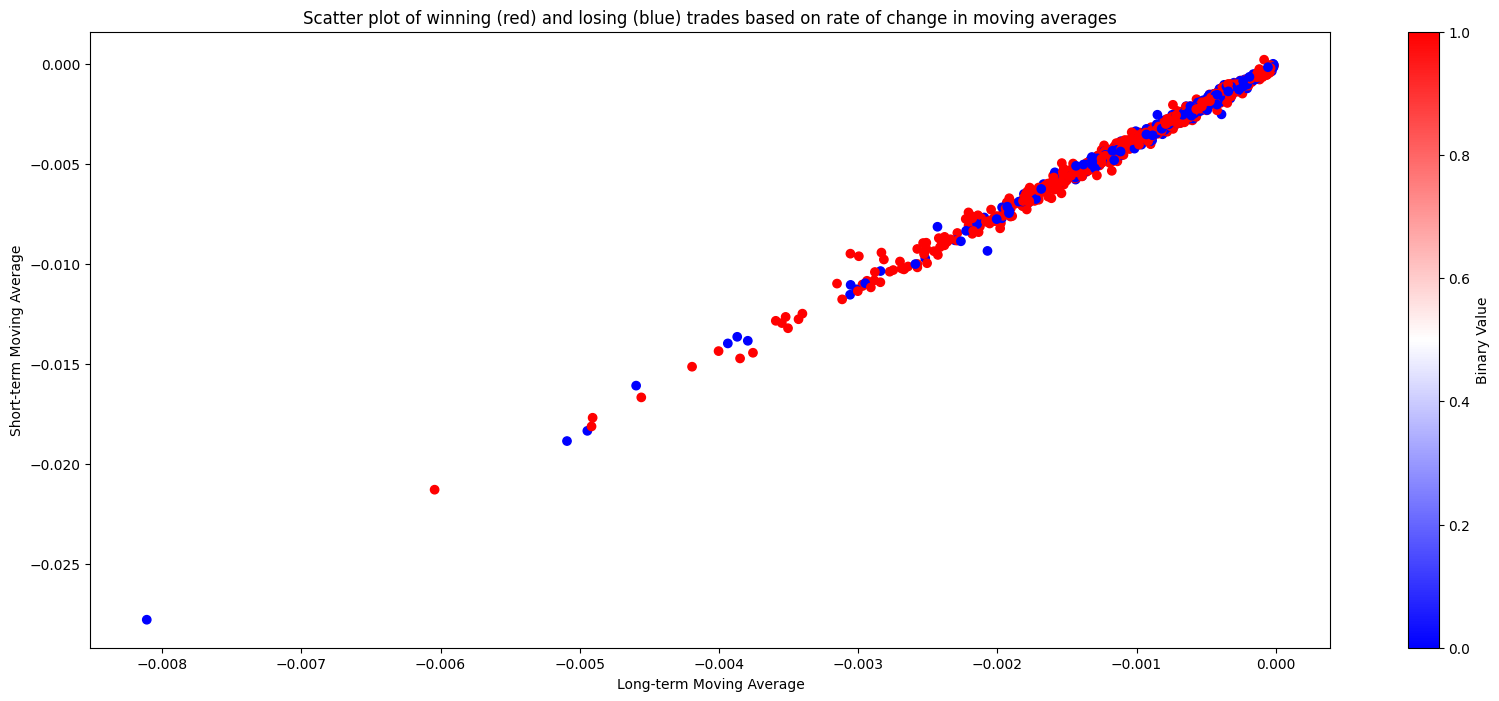

Valid crossovers: 1200
Successful crossovers: 744
1184
Amount of trades 259
Amount of successful trades 220
Accuracy: 0.6266666666666667


In [28]:

model = train_model(common_long1, large_window, small_window, window)

In [29]:
test_model(common_mid1, large_window, small_window, window, model)

Valid crossovers: 628
Successful crossovers: 457
Predicted successful crossovers: 611
Amount of trades 63
Amount of successful trades 49
Accuracy: 0.7165605095541401


(0.7777777777777778, 0.7277070063694268)

TSLA
Date: 2022-10-12 00:00:00, Buy: 208.300, Sell Date: 2022-11-07 00:00:00, Sell: 208.650, Move: 0.002, Held for 16
NIO
Date: 2021-08-24 00:00:00, Buy: 38.660, Sell Date: 2021-09-08 00:00:00, Sell: 39.170, Move: 0.013, Held for 8
NIO
Date: 2021-12-13 00:00:00, Buy: 32.230, Sell Date: 2022-01-04 00:00:00, Sell: 33.350, Move: 0.035, Held for 13
AMD
Date: 2022-02-02 00:00:00, Buy: 120.320, Sell Date: 2022-02-14 00:00:00, Sell: 115.510, Move: -0.040, Held for 6
AMD
Date: 2022-09-08 00:00:00, Buy: 84.030, Sell Date: 2022-10-13 00:00:00, Sell: 58.940, Move: -0.299, Held for 24
WBD
Date: 2022-03-21 00:00:00, Buy: 26.370, Sell Date: 2022-04-14 00:00:00, Sell: 25.890, Move: -0.018, Held for 16
WBD
Date: 2023-05-05 00:00:00, Buy: 13.000, Sell Date: 2023-06-12 00:00:00, Sell: 13.920, Move: 0.071, Held for 23
NVDA
Date: 2022-02-01 00:00:00, Buy: 257.940, Sell Date: 2022-02-11 00:00:00, Sell: 259.160, Move: 0.005, Held for 6
NVDA
Date: 2022-04-19 00:00:00, Buy: 225.170, Sell Date: 2022-05-24 00:0

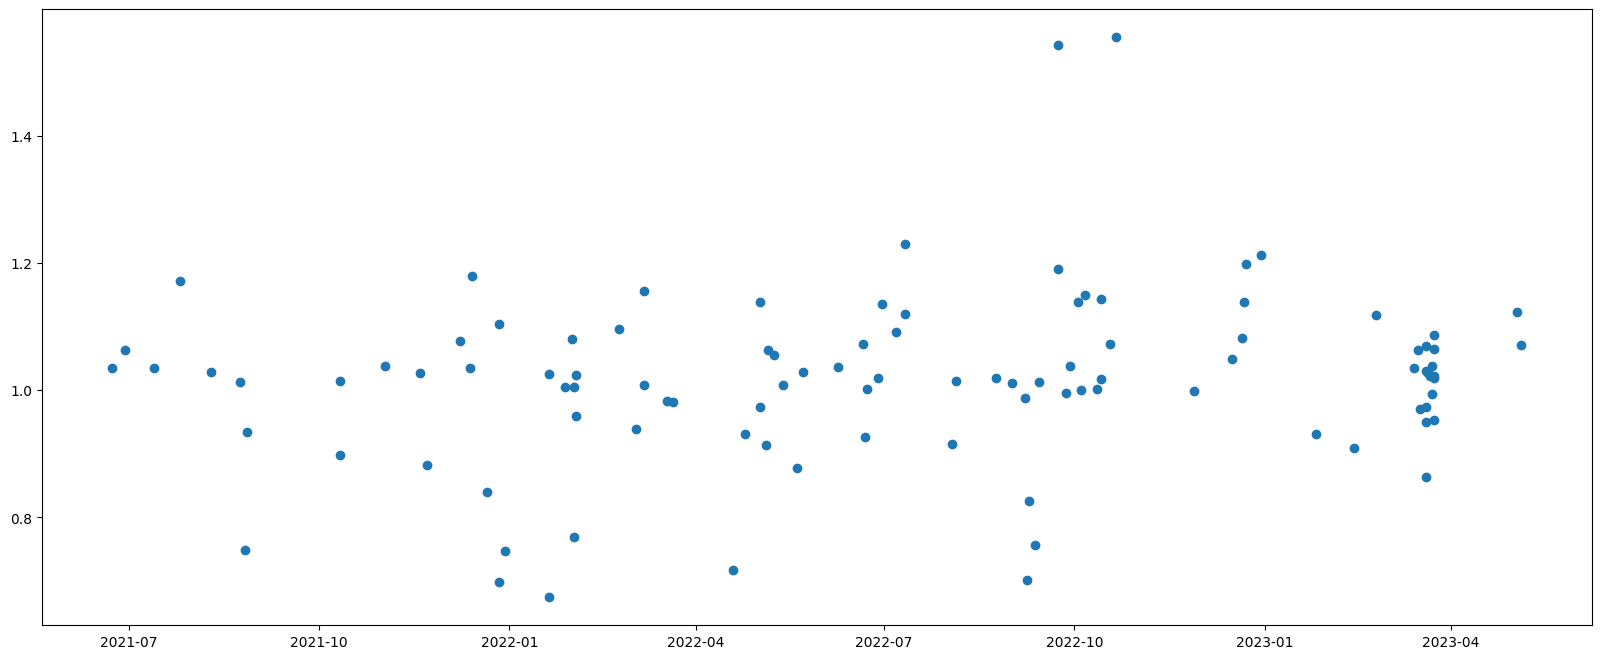

In [ ]:


def get_simulation_data(ticker_dict, window, model):
    trade_data = []
    for ticker in ticker_dict.keys():
        dataset = ticker_dict[ticker]
        for i in range(window, len(dataset) - 80):
            if dataset['SMA'][i - 6] > dataset['LMA'][i - 6] and dataset['SMA'][i - 5] <= dataset['LMA'][i - 5]:
                lma_change = (dataset['LMA'][i] - dataset['LMA'][i - 10]) / dataset['LMA'][i - 10] / 10
                sma_change = (dataset['SMA'][i] - dataset['SMA'][i - 10]) / dataset['SMA'][i - 10] / 10
                ma_change = (dataset['MA'][i] - dataset['MA'][i - 20]) / dataset['MA'][i - 20]

                if(lma_change < 0 and model.predict_proba(np.array([lma_change, sma_change]).reshape(1, -1))[0, 1] > .8):
                    date = dataset['Date'][i]
                    buy = dataset['Open'][i + 1]
                    sell = 0
                    # sell = dataset['Open'][i + 1] * 1.1 if any(value > dataset['Open'][i + 1] * 1.1 for value in future) else dataset['Close'][i + 80]
                    for n in range(i+2, i + 25):
                        if dataset['High'][n] > dataset['Open'][i + 1] * 1.04:
                            sell = dataset['Open'][n + 1]
                            sell_date = dataset['Date'][n + 1]
                            hold_period = n - (i + 1)
                        #     break
                        # if dataset['Low'][n] < dataset['Open'][i+1] * .8:
                        #     sell = dataset['Open'][i+1] * .8
                        #     sell_date = dataset['Date'][n + 1]
                        #     hold_period = n - (i + 1)
                        #     break
                    if sell == 0:
                        sell = dataset['Close'][i + 25]
                        sell_date = dataset['Date'][i + 25]
                        hold_period = i + 25 - (i + 1)
                    trade_data.append((date, buy, sell, sell_date, hold_period, ticker))
    return trade_data

def get_upward_data(ticker_dict, window):
    trade_data = []
    for ticker in ticker_dict.keys():
        dataset = ticker_dict[ticker]
        for i in range(window + 30, len(dataset) - 80):
            if dataset['SMA'][i - 31] <= dataset['LMA'][i - 31] and dataset['SMA'][i - 30] > dataset['LMA'][i - 30]:
                lma_change = (dataset['LMA'][i] - dataset['LMA'][i - 60]) / dataset['LMA'][i - 60] / 60
                sma_change = (dataset['SMA'][i] - dataset['SMA'][i - 60]) / dataset['SMA'][i - 60] / 60
                ma_change = (dataset['MA'][i] - dataset['MA'][i - 20]) / dataset['MA'][i - 20]
                angle_rad = math.atan(abs(sma_change - ma_change) / (1 + sma_change * ma_change))
                predictor = dataset['LMA'][i - 30] / dataset['SMA'][i - 30]
                if(lma_change > .0015):
                    date = dataset['Date'][i]
                    buy = dataset['Open'][i + 1]
                    future = list(dataset['High'][i+2:i+40])
                    sell = 0
                    # sell = dataset['Open'][i + 1] * 1.1 if any(value > dataset['Open'][i + 1] * 1.1 for value in future) else dataset['Close'][i + 80]
                    for n in range(i+2, i + 40):
                        if dataset['High'][n] > dataset['Open'][i + 1] * 1.05:
                            sell = dataset['Open'][n + 1]
                            sell_date = dataset['Date'][n + 1]
                            hold_period = n - (i + 1)
                            break
                        if dataset['Low'][n] < dataset['Open'][i+1] * .9:
                            sell = dataset['Open'][i+1] * .9
                            sell_date = dataset['Date'][n + 1]
                            hold_period = n - (i + 1)
                            break
                    if sell == 0:
                        sell = dataset['Close'][i + 40]
                        sell_date = dataset['Date'][i + 40]
                        hold_period = i + 40 - (i + 1)
                    trade_data.append((date, buy, sell, sell_date, hold_period, ticker))
    return trade_data

def get_downward_data(ticker_dict, window):
    trade_data = []
    for ticker in ticker_dict.keys():
        dataset = ticker_dict[ticker]
        for i in range(window + 30, len(dataset) - 80):
            if dataset['SMA'][i - 31] <= dataset['LMA'][i - 31] and dataset['SMA'][i - 30] > dataset['LMA'][i - 30]:
                lma_change = (dataset['LMA'][i] - dataset['LMA'][i - 60]) / dataset['LMA'][i - 60] / 60
                sma_change = (dataset['SMA'][i] - dataset['SMA'][i - 60]) / dataset['SMA'][i - 60] / 60
                ma_change = (dataset['MA'][i] - dataset['MA'][i - 20]) / dataset['MA'][i - 20]
                angle_rad = math.atan(abs(sma_change - ma_change) / (1 + sma_change * ma_change))
                predictor = dataset['LMA'][i - 30] / dataset['SMA'][i - 30]
                if(lma_change < -.001):
                    date = dataset['Date'][i]
                    buy = dataset['Open'][i + 1]
                    future = list(dataset['High'][i+2:i+40])
                    sell = 0
                    # sell = dataset['Open'][i + 1] * 1.1 if any(value > dataset['Open'][i + 1] * 1.1 for value in future) else dataset['Close'][i + 80]
                    for n in range(i+2, i + 40):
                        if dataset['High'][n] > dataset['Open'][i + 1] * 1.05:
                            sell = dataset['Open'][n + 1]
                            sell_date = dataset['Date'][n + 1]
                            hold_period = n - (i + 1)
                            break
                        if dataset['Low'][n] < dataset['Open'][i+1] * .9:
                            sell = dataset['Open'][i+1] * .9
                            sell_date = dataset['Date'][n + 1]
                            hold_period = n - (i + 1)
                            break
                    if sell == 0:
                        sell = dataset['Close'][i + 40]
                        sell_date = dataset['Date'][i + 40]
                        hold_period = i + 40 - (i + 1)
                    trade_data.append((date, buy, sell, sell_date, hold_period, ticker))
    return trade_data

def simulate_model(ticker_dict, window, model):
    trade_data = []
    trade_data = get_simulation_data(ticker_dict, window, model)
    # up_data = get_upward_data(ticker_dict, window)
    # down_data = get_downward_data(ticker_dict, window)

    # trade_data += up_data
    # trade_data += down_data

    trade_df = pd.DataFrame(trade_data, columns=['Date', 'Buy', 'Sell', 'Sell_date', 'Hold', 'Ticker'])

    trade_df['Date'] = pd.to_datetime(trade_df['Date'])
    count = 0
    total = 0
    profit = 0
    move = []
    for index, row in trade_df.iterrows():
        if row["Buy"] < row["Sell"]:
            count += 1
        percent = row["Sell"] / row["Buy"] - 1
        move.append(percent)

        total += 1
        profit += 1000 * row["Sell"] / row["Buy"] - 1000
        print(row['Ticker'])
        print("Date: {}, Buy: {:.3f}, Sell Date: {}, Sell: {:.3f}, Move: {:.3f}, Held for {}".format(row["Date"], row["Buy"], row['Sell_date'], row["Sell"], percent, row['Hold']))


    loss = [m for m in move if m < 0]
    win = [w for w in move if w > 0]
    print(count)
    print(total)
    print(np.mean(win))
    print(np.mean(loss))
    print(np.mean(trade_df['Hold']))

    percent = trade_df["Sell"] / trade_df["Buy"] 

    plt.figure(figsize = (20, 8))
    plt.scatter(trade_df['Date'], percent)

simulate_model(common_short1, window, model)

    





    

In [30]:

def get_signal_data(ticker_dict, window, model):
    trade_data = []
    for ticker in ticker_dict.keys():
        dataset = ticker_dict[ticker]
        for i in range(20, len(dataset)):
            if dataset['SMA'][i - 6] > dataset['LMA'][i - 6] and dataset['SMA'][i - 5] <= dataset['LMA'][i - 5]:
                lma_change = (dataset['LMA'][i] - dataset['LMA'][i - 10]) / dataset['LMA'][i - 10] / 10
                sma_change = (dataset['SMA'][i] - dataset['SMA'][i - 10]) / dataset['SMA'][i - 10] / 10
                ma_change = (dataset['MA'][i] - dataset['MA'][i - 20]) / dataset['MA'][i - 20]

                if(lma_change < 0 and model.predict_proba(np.array([lma_change, sma_change]).reshape(1, -1))[0, 1] > .8):
                    date = dataset['Date'][i]
                    buy = dataset['Open'][i + 1]
                    sell = 0
                    # sell = dataset['Open'][i + 1] * 1.1 if any(value > dataset['Open'][i + 1] * 1.1 for value in future) else dataset['Close'][i + 80]
                    trade_data.append((date, buy, ticker, i))
    return trade_data

def create_trade_signals(ticker_dict, window, initial_capital, trade_amount, model):
    capital = initial_capital
    trade_data = get_signal_data(ticker_dict, window, model)
    # up_data = get_upward_data(ticker_dict, window)
    # down_data = get_downward_data(ticker_dict, window)

    # trade_data += up_data
    # trade_data += down_data

    trade_df = pd.DataFrame(trade_data, columns=['Date', 'Buy', 'Ticker', 'i'])
    sorted_df = trade_df.sort_values(by='Date')
    sorted_df = sorted_df.reset_index(drop=True)

    date_range = pd.date_range(start= "2000-05-03", end= "2023-05-03")
    date_list = date_range.tolist()

    # positions = []

    wins = []
    loss = []



    for i in date_list:
        # Buy positions the next day


        # Sell positions

        # Mark position for selling



        # Create buy signal
        for n in range(len(sorted_df['Date'])):
            if sorted_df['Date'][n] == i and capital > trade_amount:
                # capital -= trade_amount
                print(sorted_df['i'][n])
                print("Buy {} on {}: {:.3f}".format(sorted_df['Ticker'][n], sorted_df['Date'][n], sorted_df['Buy'][n]))
                # positions.append([sorted_df['Buy'][n], sorted_df['Sell'][n], sorted_df['Sell_date'][n], sorted_df['Hold'][n], sorted_df['Ticker'][n]])

    # print((capital + len(positions) * trade_amount) / initial_capital)
    # print(len(wins))
    # print(len(loss))
    # print(wins)
    # print(loss)
    # print(np.mean(wins))
    # print(np.mean(loss))
    

create_trade_signals(common_short1, window, 7000, 1500, model)

26
Buy OPEN on 2022-09-07 00:00:00: 4.348
26
Buy SHOP on 2022-09-07 00:00:00: 30.420
27
Buy DELL on 2022-09-08 00:00:00: 38.870
27
Buy HPQ on 2022-09-08 00:00:00: 27.720
29
Buy SOFI on 2022-09-12 00:00:00: 6.020
29
Buy CHWY on 2022-09-12 00:00:00: 35.160
31
Buy IOT on 2022-09-14 00:00:00: 13.070
39
Buy OLN on 2022-09-26 00:00:00: 43.320
40
Buy F on 2022-09-27 00:00:00: 11.910
41
Buy DISH on 2022-09-28 00:00:00: 14.510
43
Buy HAL on 2022-09-30 00:00:00: 25.990
45
Buy SWN on 2022-10-04 00:00:00: 7.100
48
Buy LYFT on 2022-10-07 00:00:00: 12.810
51
Buy PLUG on 2022-10-12 00:00:00: 17.900
55
Buy TAL on 2022-10-18 00:00:00: 3.840
57
Buy S on 2022-10-20 00:00:00: 22.500
57
Buy DKNG on 2022-10-20 00:00:00: 13.120
61
Buy DNA on 2022-10-26 00:00:00: 2.880
77
Buy RBLX on 2022-11-17 00:00:00: 33.080
77
Buy BBD on 2022-11-17 00:00:00: 2.920
147
Buy KGC on 2023-03-02 00:00:00: 3.780
150
Buy LU on 2023-03-07 00:00:00: 2.090
155
Buy SCHW on 2023-03-14 00:00:00: 57.050
155
Buy BABA on 2023-03-14 00:00: